# Kalman Filter, Hungarian Algorithm을 통한 SORT Algorithm


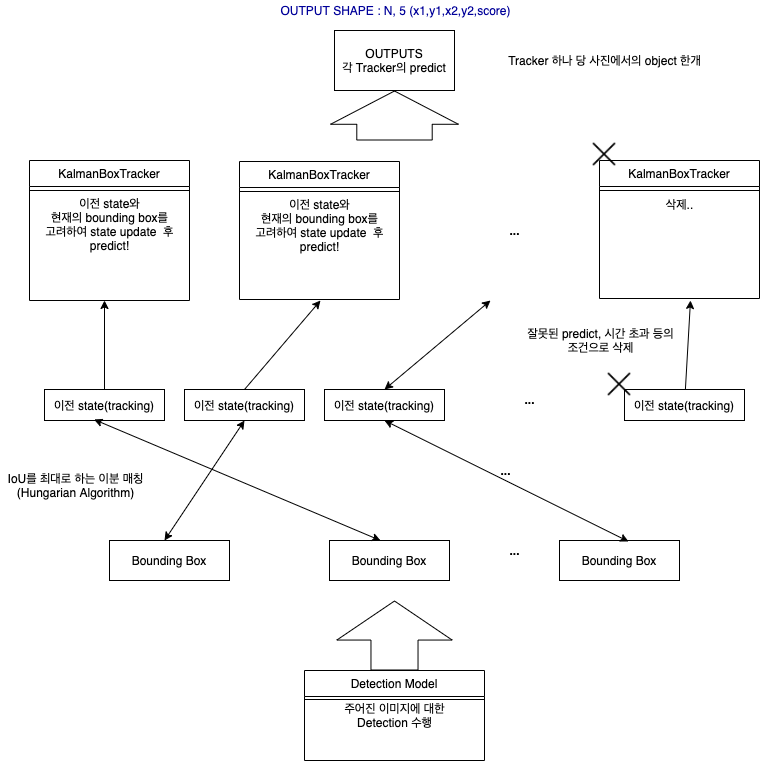



In [ ]:
"""
    SORT : A Simple, Oline and Realtime Tracker
"""

import os
import numpy as np

from filterpy.kalman import KalmanFilter

## Utils

### Utils
**linear_assignment** :  
Input : 모든 detection된 boxes와 tracking된 boxes 사이의 iou(cost) 값들 (permutation) table  
Output : 이에 대한 전체 iou를 가장 높게 하는 matching indices. shape : (matching num, 2)  
<br>
**iou_batch** :  
Input : detection된 boxes, tracking boxes  
Output : permutation 형태의 IoU table 형성. shape : (detection_num, tracking_num)  
<br>



In [ ]:
np.random.seed(0)

"""
    이분 매칭에 있어서 minimum weight matching
    
"""

def linear_assignment(cost_matrix): # Hungarian Algorithm
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost = True)
        return np.array([[y[i],i] for i in x if i>= 0])
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x,y)))

def iou_batch(bb_test, bb_gt): # bb_gt -> real_bb_num, 4      bb_test -> pre_bb_num, 4
    bb_gt = np.expand_dims(bb_gt, 0) # ground truth의 경우 실제 object의 갯수 m
    bb_test = np.expand_dims(bb_test, 1) # pred의 경우 갯수가 다를수도. n 얘네들 끼리 cost (iou)를 구하자.
    """
        shape.
        bb_gt : 1, real_bb_num, 4
        bb_test : pred_bb_num, 1, 4
        
        permutation 형식으로 비교하게 된다. (test에 존재하는 bbs와 gt에 존재하는 bbs끼리)
    """

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0]) # shape : pred_bb_num, real_bb_num
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w*h
    o = wh/ ((bb_test[...,2] - bb_test[..., 0]) * (bb_test[...,3]-bb_test[...,1])
             +(bb_gt[...,2] - bb_gt[..., 0])*(bb_gt[...,3] - bb_gt[..., 1]) - wh)
    return (o)

"""
    sort에 사용되는 kalman filter의 state에 대한 input 형태는
    (cx, cy, area_scale, ratio w/h)
    x1, y1, x2, y2 -> x,y,s,r
    
"""
def convert_bbox_to_z(bbox):
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w*h
    r = w/float(h)
    return np.array([x,y,s,r]).reshape((4,1)) # shape은 4,1


"""
    output에 score도 포함시켜주자.
    시각화 및 출력의 형태로 바꿔줘야함.
    z -> bbox
    x,y,s,r -> x1, y1, x2, y2
"""
def convert_x_to_bbox(x, score=None):
    w = np.sqrt(x[3]*x[2])
    h = x[2] / w
    if(score == None):
        return np.array([x[0]-w/2., x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else :
        return np.array([x[0]-w/2., x[1]-h/2.,x[0]+w/2.,x[1]+h/2., score]).reshape((1,5))


## 사용자 정의 KalmanTracker

**Class KalmanBoxTracker**  
  
\__init__ : Kalmanfilter module 초기화
<br>
update (bbox) : detection된 bbox와 이 전의 state에 대해 kalmanfilter module update
<br>
predict() : update된 정보를 기반으로 bbox, score 계산.


In [ ]:
class KalmanBoxTracker(object):
    count = 0
    def __init__(self, bbox): # 초기 bbox를 넣어주자.

        self.kf = KalmanFilter(dim_x=7, dim_z = 4) # x(state)의 형태, z(output)의 형태
        """
            x,y,s,r,x',y',s' (state)
            x -> x'
            y -> y'
            s -> s'
            r -> r (constant)
        """
        # State transistion matrix
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        # Measure function
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        # 다변량 가우시안으로 모델링 되었다면 parameter로서의 공분산은 gaussian distribution의 불확정성을 의미한다.
        # 간단하게 univariable gaussian distribution의 sigma 파라미터에 대한 불확정성의 관계성을 생각해보자.
        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. # x', y', s' 미래에 대한 내용. uncertainty를 높게 부여해주자. (공분산 값 높이기)
        self.kf.P *= 10.
        # Q : process uncertainty
        self.kf.Q[-1,-1] *= 0.01 # process의 불확정성 이라고한다.
        self.kf.Q[4:,4:] *= 0.01 # x', y', s'


        self.kf.x[:4] = convert_bbox_to_z(bbox) # 반복적으로 현재의 bbox를 가져온다.
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count +=1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self,bbox):
        """
            observed box를 토대로 state vector를 update 한다.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak +=1
        self.kf.update(convert_bbox_to_z(bbox)) # bbox를 z로 (할당 해주는 듯)

    def predict(self):

        if (self.kf.x[6]+self.kf.x[2] <= 0):
            self.kf.x[6] *= 0.0  # 그 다음 scale이 음수로 되버린 경우 인듯.
        self.kf.predict()
        self.age +=1
        if (self.time_since_update >0):
            self.hit_streak = 0
        self.time_since_update +=1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        return convert_x_to_bbox(self.kf.x)


## Bipartite Matching _ Hungarian Algorithm

In [ ]:



"""
    detections : pred
    trackers : gt
"""

def associate_detections_to_trackers(detections, trackers, iou_threshold = 0.3):
    if (len(trackers)==0):
        return np.empty((0,2), dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0: # pred(detection)과 gt(trackers)의 수가 0이 아닌 경우
        a = (iou_matrix > iou_threshold).astype(np.int32) # iou threshold가 0.3 이상인 것만 고려.(mask)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1: # m x n x 4 ..에서 iou threshold 넘는게 하나만 존재 한다면.
            matched_indices = np.stack(np.where(a), axis =1) # 하나만 고려하면 된다. 한 pair로 stack(bbox)에 대한 위치들을 뽑아준다.
            # pred [i,j,k] - gt [i',j',k'] [[i,j,k],[i',j',k']]
        else :
            matched_indices = linear_assignment((-iou_matrix)) # iou가 높은걸 선택해야해서, -붙여주자.
    else :
        matched_indices = np.empty(shape=(0,2)) # 좌표 없음.

    unmatched_detections = [] # index로 이루어진 리스트.
    for d, det in enumerate(detections): # pred
        if (d not in matched_indices[:,0]): # pred가 첫번째다. 여기에서 detection의 각 index가 존재하지 않으면 Unmatch 된 것
            unmatched_detections.append(d)
    # trackers도 마찬가지.
    unmatched_trackers = []
    for t, trk in enumerate(trackers):  # pred
        if (t not in matched_indices[:, 1]):  # pred가 첫번째다. 여기에서 detection의 각 index가 존재하지 않으면 Unmatch 된 것
            unmatched_trackers.append(t)

    # iou threshold를 넘지 못하는 녀석들을 filtering 해주자. (위 조건식에서는 1개 존재할때만 처리함.)

    matches = []
    for m in matched_indices: # 여러 오브젝트에 대한 pair [pred_index, gt_index]로 이루어진 list
        if (iou_matrix[m[0],m[1]] < iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else :
            matches.append(m.reshape(1,2)) # 걸러지지 않는다면 matches에 넣어주자. 1,2 형태.

    if len(matches) == 0:
        matches = np.empty((0,2), dtype=int)
    else :
        matches = np.concatenate(matches, axis=0) # list에 (1,2)형태의 여러개 np array 존재 -> 1, 2에서 1 들을 합쳐주자.

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


## SORT Class

**Class Sort**<br>
\__init__ : trackers (여러 object(bbox)에 대한 각각의 trackers(kalman filter class)) 등 사용되는 속성 선언<br>
<br>
update : Input으로 current detection bboxes를 받고 이전 tracking된 pos들과 이분매칭 후 올바르지 않은 값을 갖는 tracker는 삭제하고 <br>matching 된 오브젝트에 대한 tracker를 matching detection box에 대해 update, <br>unmatched 된 object는 새롭게 tracker를 생성한다.
<br>
**특정 조건을 만족하는 (프레임 유지 등) 트래커에 대해서 predict 정보를 받는다**


In [ ]:

"""
    Sort Class
"""

class Sort(object):
    def __init__(self, max_age = 1, min_hits = 3, iou_threshold = 0.3):

        self.max_age = max_age # 최대 나이. (없애는 기준)
        self.min_hits = min_hits # 판정 기준. (어느정도 프레임을 유지해야 포함 시킬 수 있음.)
        self.iou_threshold = iou_threshold
        self.trackers = [] # class KalmanBoxTracker로 이루어진 리스트. 이에 대한 클래스를 가져와서 사용할 거임.
        self.frame_count = 0

    def update(self, dets=np.empty((0,5))): # 어떤 모델에서 detection 됌. format : [x1,y1,x2,y2, score]
        self.frame_count +=1
        trks = np.zeros((len(self.trackers), 5)) # object 개수.
        to_del = []
        ret = []
        for t, trk in enumerate(trks): # 이전을 기반으로 ! (없으면 0임)
            pos = self.trackers[t].predict()[0]
            trk[:] = [pos[0], pos[1], pos[2], pos[3], 0] # score는 아직 몰라
            if np.any(np.isnan(pos)):
                to_del.append(t) # nan 값이 하나라도 존재한다면 없애버리기
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks)) # mask를 포함하는.
        for t in reversed(to_del):
            self.trackers.pop(t) # 잘못된 kalmanfilterclass 제거
        matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets, trks,self.iou_threshold)

        for m in matched:
            self.trackers[m[1]].update(dets[m[0], :])# match된 pair index 중 tracker index에 맞는 tracker를 불러오고 이에 맞는 detection box에 대해 update

        for i in unmatched_dets:
            trk= KalmanBoxTracker(dets[i,:]) # 존재하는 unmatched det들에 대해 (새로운 오브젝트가 나타난 경우)
            self.trackers.append(trk) # 만드러진 트래커를 추가해주자. object 하나당 Tracker를 생성해준다.
        i = len(self.trackers)
        for trk in reversed(self.trackers):
            d = trk.get_state()[0] # bbox, score
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count<= self.min_hits):
                ret.append(np.concatenate((d,[trk,id+1])).reshape(1,-1))
            i -=1
            if trk.time_since_update > self.max_age :
                self.trackers.pop(i) # 오래 사용이 안된다면 없애버리자
        if len(ret)< 0:
            return np.concatenate(ret)
        return np.empty((0,5)) # 아무것도 없어..

